# Indexation d'images par la couleur

## 1. Lecture d'une image RGB

In [1]:
from scipy.misc import imread

img = imread('img/45.jpg')
print('Shape:', img.shape)

Shape: (200, 200, 3)


L'image fait 200 pixels en hauteur et 200 pixels en largeur; chaque pixel est composé de 3 valeurs (les intensités de rouge, de vert et de bleu). On peut afficher l'image avec la fonction `imshow` de Matplotlib.

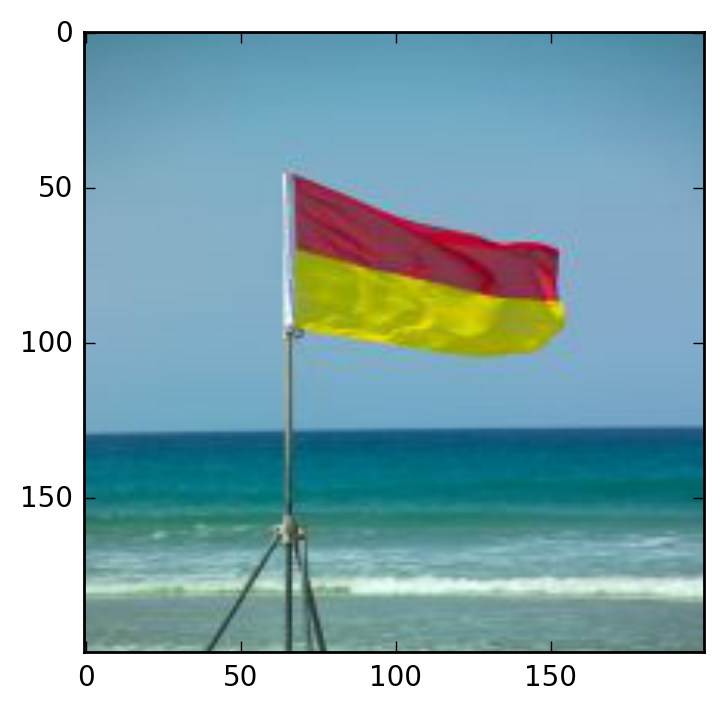

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(img)

## 2. Quantification de la couleur

> Nous allons tout d'abord quantifier l'image : celle-ci est effectuée par sous-échantillonnage sur les 2 bits de poids forts pour chaque composante. Ecrire une fonction quantification qui effectue cette opération. Nous utiliserons la fonction bitand afin d'accéder à la valeur d'un bit. Exemple pour récupérer la valeur du 1er bit de poids fort (bit7 --> 2^7 = 128) du nombre n : bitand(n, 128) /128 renverra 0 ou 1.

In [2]:
def sample_pixel(pixel):
    to_bits = lambda x: '{0:08b}'.format(x)
    r, g, b = to_bits(pixel[0]), to_bits(pixel[1]), to_bits(pixel[2])
    r_intensity = int(r[0]) * 2 ** 5 + int(r[1]) * 2 ** 4
    g_intensity = int(g[0]) * 2 ** 3 + int(g[1]) * 2 ** 2
    b_intensity = int(b[0]) * 2 ** 1 + int(b[1]) * 2 ** 0
    intensity = r_intensity + g_intensity + b_intensity
    return [intensity, intensity, intensity] # Nécessaire d'en mettre 3 pour l'affichage


def sample_image(image):
    return [
        [
            sample_pixel(pixel)
            for pixel in row
        ]
        for row in image
    ]

> Afficher le résultat sous la forme d'une image. Que remarquez-vous ?

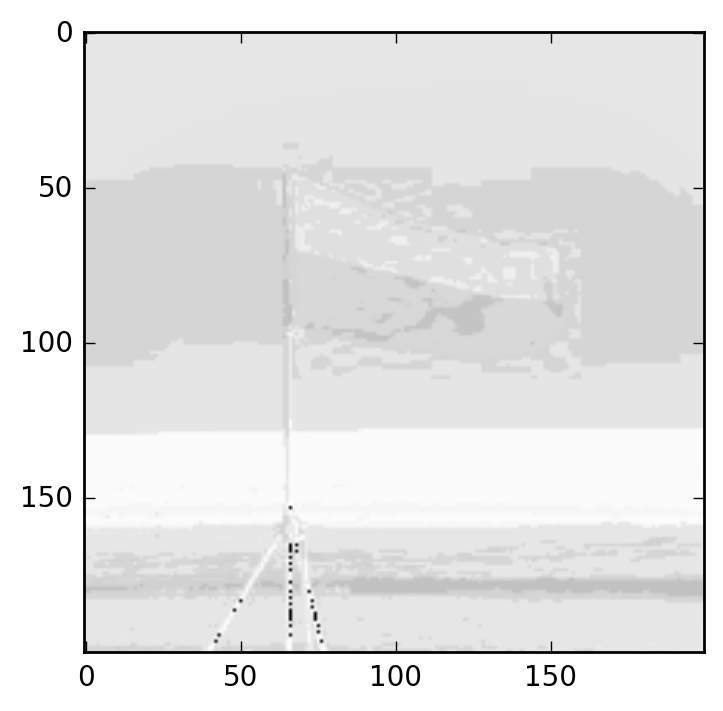

In [6]:
sample = sample_image(img)
plt.imshow(sample)

L'image est grise car on est passé en niveaux de gris. En niveau de gris une seule valeur est nécessaire alors que système RGB il en faut 3.

## 3. Histogramme de couleur

> Nous allons maintenant indexer cette image par son histogramme de couleur. Ecrire une fonction histogramme qui calcule l'histogramme correspondant. Afficher le résultat.

La méthode `sample_image` retourne 3 valeurs pour chaque pixel pour la liste de listes retournées puisse être affichée. Si on fait l'histogramme de couleurs il y'aura 3 fois trop de valeurs et l'histogramme sera faussé. On convertit donc la liste de listes en `array` numpy pour pouvoir extraire la première de chaque triplet d'intensité.

<Container object of 64 artists>

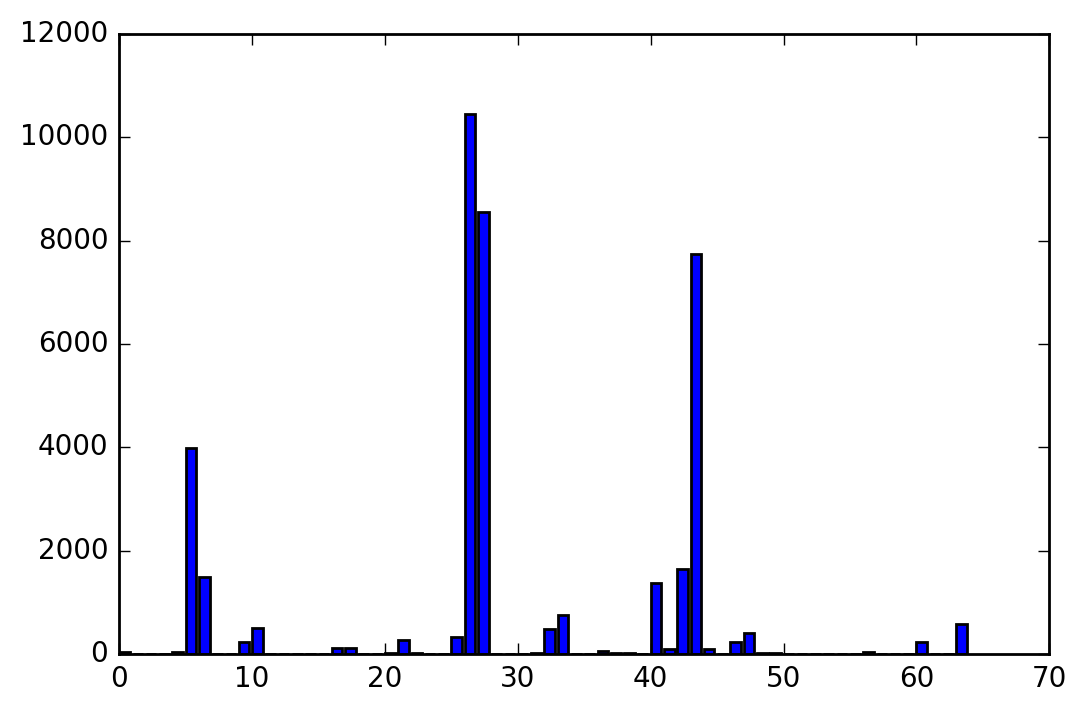

In [20]:
import numpy as np
from scipy.ndimage.measurements import histogram

hist = histogram(np.array(sample)[:, :, 0], min=0, max=63, bins=64)

plt.bar([i for i in range(64)], hist)

## 4. Indexation d'image

> Ecrire une fonction indexation qui applique le processus sur chaque image et mémorise l'histogramme obtenu à chaque fois.

On peut plutôt stocker tous les histogrammes dans un dictionnaire où les clés sont numéros de chaque fichier et les valeurs sont les histogrammes. On écrit quelques fonctions avec de faire cela pour gagner en lisibilité.

In [25]:
from os import listdir
import time

def load_image(path):
    return imread('img/{}'.format(path))

def compute_histogram(image):
    return histogram(image, min=0, max=63, bins=64)

debut = time.time()

histograms = {
    i: compute_histogram(np.array(sample_image(load_image(path)))[:, :, 0])
    for i, path in enumerate(listdir('img/'))
}

fin = time.time()

print('{0:.2f} secondes au total'.format(fin - debut))
print('{0:.2f} secondes par image'.format((fin - debut) / len(histograms)))

23.00 secondes au total
0.46 secondes par image


Cette opération prend un peu de temps, elle irait bien plus vite si on vectorisait la fonction `sample_image`, mais cela sort du cadre du TP. 

## 5. Recherche d'images similaires par la couleur

> Ensuite, demander à l'utilisateur d'entrer le numéro d'une image et renvoyer les 5 images les plus similaires. La similarité sera calculé en fonction d'une distance du type intersection d'histogrammes sur les histogrammes en couleur issus de l'indexation.

La distance que l'on utilise est la suivante (où les $h_i$ sont les histogrammes).

$$d(h_{1},h_{2})=\sum _{i=1}^{N}\min \left[h_{1}(i),h_{2}(i)\right]$$

Pour ce faire, on va trier le dictionnaire contenant les histogrammes en prenant comme mesure de comparaison la distance de chaque histogramme avec l'histogramme de l'image par l'utilisateur.

In [32]:
def histogram_intersection(h1, h2):
    return sum(((min(v1, v2) for v1, v2 in zip(h1, h2))))


# Image demandée
target_img = 45

neighbours = sorted(histograms.items(), key=lambda x: histogram_intersection(x[1], histograms[target_img]))[-6:-1]

for i, neighbour in enumerate(reversed(neighbours)):
    print('Image la plus ressemblante {}:'.format(i+1), neighbour[0])

Image la plus ressemblante 1: 46
Image la plus ressemblante 2: 12
Image la plus ressemblante 3: 21
Image la plus ressemblante 4: 26
Image la plus ressemblante 5: 43
